In [1]:
import pandas as pd
import numpy as np
import librosa 
import matplotlib.pyplot as plt
import statistics
from pydub.silence import split_on_silence
from pydub import AudioSegment, effects 
from scipy.io.wavfile import read, write

/home/michael/.local/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# train_csv = pd.read_csv('training_data.csv')
# train_csv.head()

def get_windows(audio, window_size = 11025):
    
    start = 0
    windows = []
    audio_len = len(audio)
    
    while start < audio_len:
        
        #find window end
        if start+window_size > audio_len:
            break
        else: 
            window_end = int(start + window_size)
            
        #take window 
        window = audio[start:window_end]
    
        windows.append(window)
        #move window
        start += int(window_size / 2) 
        
    return windows

#! failed - not sure amplitude scaling is possible at the moment
def amplitude_scaling(mel_spec, scaler = 0.50):
    
    mel_spec_copy = mel_spec
    
    shape = np.shape(mel_spec)
    print(f'shape = {shape}')
    
    scaler = scaler
    halfway = (shape[0] / 2)-1
    multipler = (100/halfway)/100
    scale_feature = lambda x: -abs(abs(x)-(abs(x)*scaler))
    
    print(f'scaler ={scaler}, halfway = {halfway}, multipler = {multipler}')
    
    convert = lambda x : x-(x*scaler)
    
    for index_c,column in enumerate(mel_spec):
        for index_e, element in enumerate(column): 
            
            mel_spec_copy[index_c][index_e] = convert(element)
            
            if index_e < halfway:
                scaler+=multipler
            elif index_e == halfway:
                pass
            else:
                scaler-=multipler
            
    return mel_spec_copy
              

                

In [3]:
train_csv = pd.read_csv('/home/michael/Documents/VScode/Uni/Advanced AI/project_ideas/archive/Metadata_Train.csv')
test_csv = pd.read_csv('/home/michael/Documents/VScode/Uni/Advanced AI/project_ideas/archive/Metadata_Test.csv')
train_csv.head()

,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar
2,1-E1-Major 02.wav,Sound_Guitar
3,1-E1-Major 03.wav,Sound_Guitar
4,1-E1-Major 04.wav,Sound_Guitar


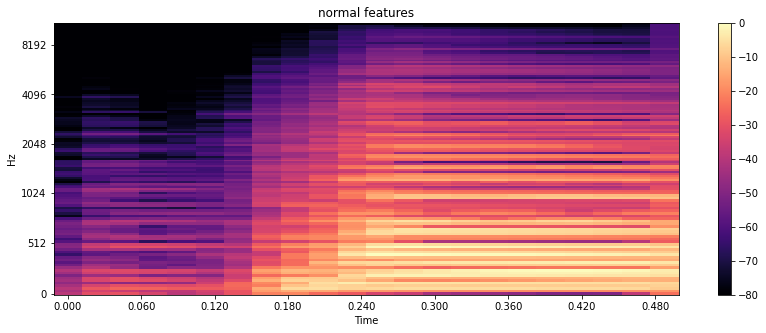

In [16]:
filename = train_csv['FileName'].iloc[0]
audio, sr = librosa.load(f'/home/michael/Documents/VScode/Uni/Advanced AI/project_ideas/archive/Train_submission/Train_submission/{filename}')
s

small_windows = get_windows(audio=audio, window_size=(sr/2))
standard_windows = get_windows(audio=audio)

plt.figure(figsize=(14,5))

mel = librosa.feature.melspectrogram(y=small_windows[0], sr=sr)
mel_to_db = librosa.power_to_db(mel, ref=np.max)
librosa.display.specshow(mel_to_db, sr=22050, x_axis='time', y_axis='mel')
plt.title('normal features')
plt.colorbar()

mean_values = [statistics.mean([column[x] for column in mel_to_db]) for x in range(22)]

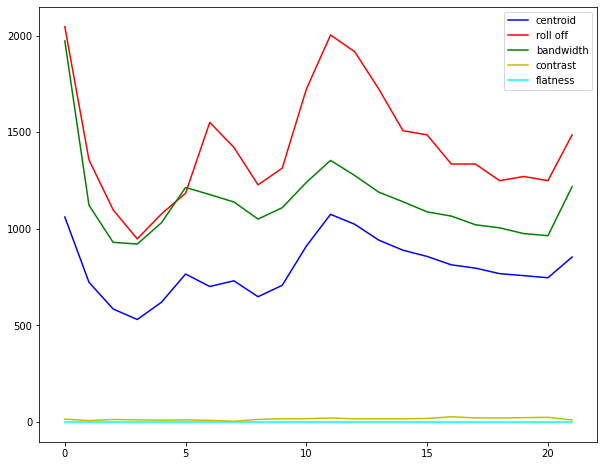

In [20]:
t = np.arange(22)

centroid = librosa.feature.spectral_centroid(y=small_windows[0], sr=sr, n_fft=1024, hop_length=512)[0]
roll_off = librosa.feature.spectral_rolloff(y=small_windows[0], sr=sr, n_fft=1024, hop_length=512)[0]
bandwidth = librosa.feature.spectral_bandwidth(y=small_windows[0], sr=sr, n_fft=1024, hop_length=512)[0]
contrast = librosa.feature.spectral_contrast(y=small_windows[0], sr=sr, n_fft=1024, hop_length=512)[0]
flatness = librosa.feature.spectral_flatness(y=small_windows[0], n_fft=1024, hop_length=512)[0]

plt.figure(figsize=(10,8))
plt.plot(t, centroid, color='b', label='centroid')
plt.plot(t, roll_off, color='r', label='roll off')
plt.plot(t, bandwidth, color='g', label='bandwidth')
plt.plot(t, contrast, color='y', label='contrast')
plt.plot(t, flatness, color='aqua', label='flatness')
plt.legend()
plt.show()
# np.shape(t)